# Tensorflow2 KeyNotes
### ==== Time Series Forecasting with Neural Networks (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the time series forecasting by using variant neural network architectures, the results derived from different neural networks are quantitatively compared. The following contents are included in this notebook:

1. Time series forecasting by using a dense neural network.
2. Time series forecasting by using a simple recurrent neural network.
3. Time series forecasting by using a deep recurrent neural network. 
4. Time series forecasting by using a deep convolutional neural network.

### Code by Hao, Zhao, Aug, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack
import time

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten

----------------------------------------------------------------------
## Data Generation
----------------------------------------------------------------------
### Generate a synthetic time series based on sinusoid signals



In [3]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2       = 30,100,200
SNR            = 20       
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t)  
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))


### Plot the generated time series

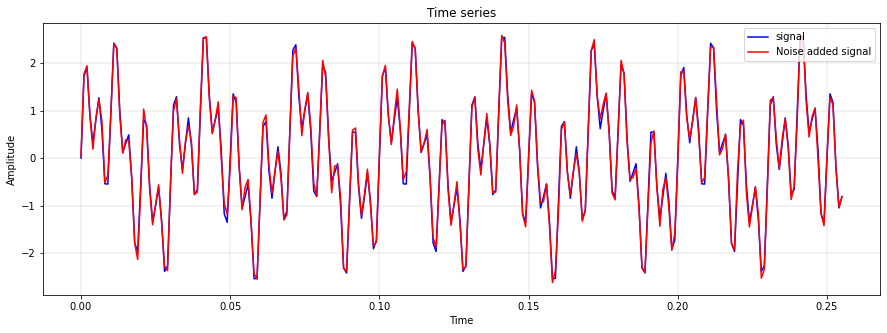

In [4]:

#set the samples to display
N=256

plt.figure(0,figsize=(15, 5))
plt.plot(t[0:N],syn_sig[0:N],'b',label='signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Dataset preprocessing to generate the training and testing datasets

In [5]:

# define the function for datasets generation 

def dataset_generation(time_series,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_x     = data_batch[0:batch_size-predict_step]
        data_y     = data_batch[batch_size-predict_step:batch_size]
    
        dataset_x  = np.concatenate((dataset_x, data_x))
        dataset_y  = np.concatenate((dataset_y, data_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,len(data_x)))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,len(data_y)))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 256
window_step  = batch_size//8
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (494, 246)
train_set_y: has shape (494, 10)
test_set_x: has shape (124, 246)
test_set_y: has shape (124, 10)


## Time series forecasting with Neural Networks


----------------------------------------------------------------------
## Method-1: Dense neural network 
----------------------------------------------------------------------


 ### Build the neural network 

In [6]:
model = Sequential([Dense(32, activation='relu',input_shape=(batch_size-predict_step,)),
                    Dropout(0.1),
                    Dense(16,activation='relu'),
                    Dropout(0.1),
                    Dense(predict_step)
                    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [7]:
start      = time.time()
history    = model.fit(train_set_x,train_set_y,epochs=100,validation_split=0.10,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Training completed in : 3779.35ms


### Display of training and validation losses in the network training


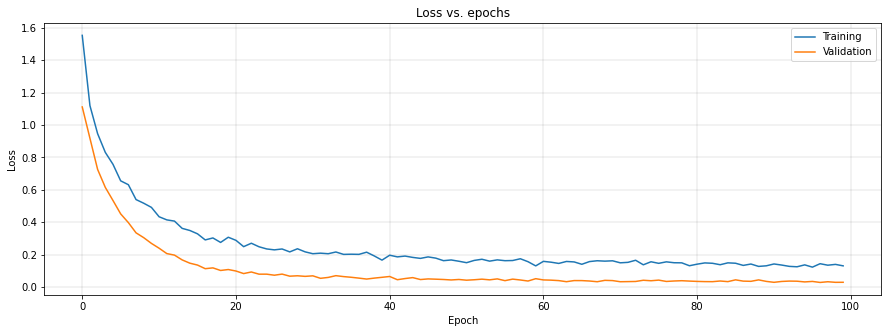

In [8]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned dense neural network


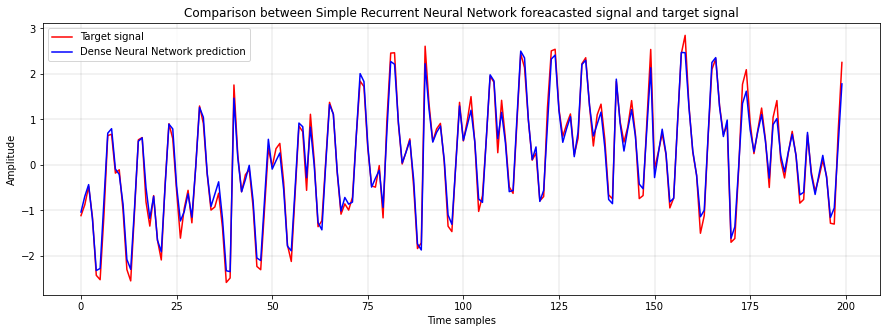

Neural network SNR: 17.270932527535777
Mean Square Error: 0.028127808183089114


In [9]:
dnn_predictions = model.predict(test_set_x)
dnn_err         = dnn_predictions - test_set_y

plt.figure(3,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(dnn_predictions[:20,:].flatten(),'b',label='Dense Neural Network prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

dnn_mse    = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Neural network SNR:", dnn_sigpow - dnn_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)))



----------------------------------------------------------------------
## Method-2: Simple recurrent neural network 
----------------------------------------------------------------------


 ### Build a simple recurrent neural network

In [10]:
model_simple_rnn = Sequential([SimpleRNN(20,input_shape=[batch_size-predict_step,1]),
                               Dense(predict_step)])

model_simple_rnn.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mae'])

model_simple_rnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 20)                440       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [11]:
start      = time.time()
history    = model_simple_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Training completed in : 116755.58ms


### Display of training and validation losses in the network training

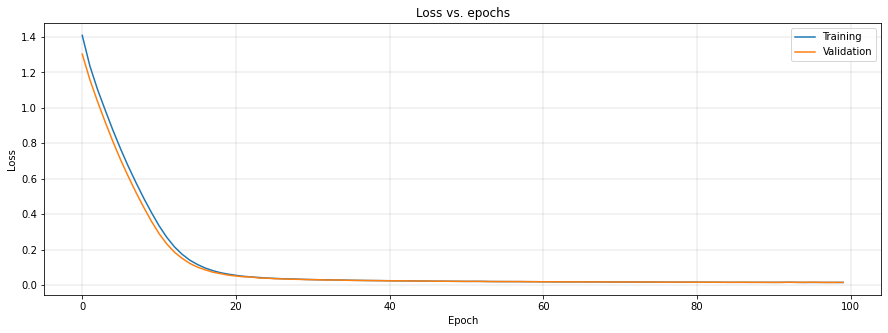

In [12]:
plt.figure(4,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

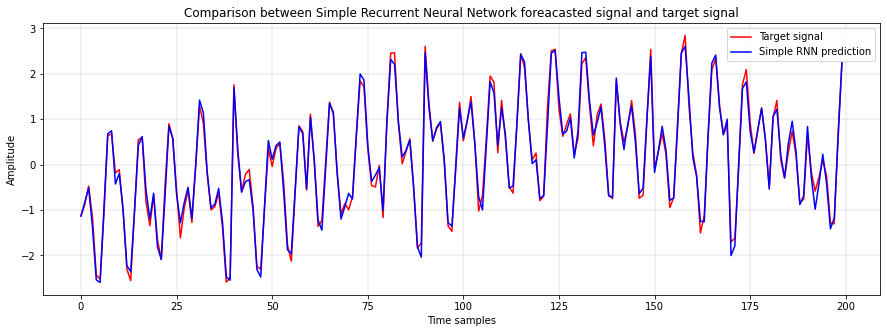

Simple Recurrent Neural network's SNR: 19.890538493731036
Mean Square Error: 0.015387756139557356


In [13]:
simple_RNN_predictions = model_simple_rnn.predict(test_set_x[...,np.newaxis])
simple_RNN_err         = simple_RNN_predictions - test_set_y

plt.figure(5,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(simple_RNN_predictions[:20,:].flatten(),'b',label='Simple RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

simple_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(simple_RNN_err),2)))
simple_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Simple Recurrent Neural network's SNR:", simple_RNN_sigpow - simple_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(simple_RNN_predictions,test_set_y)))

----------------------------------------------------------------------
## Method-3: Deep recurrent neural network 
----------------------------------------------------------------------


 ### Build a Deep recurrent neural network

In [14]:
model_deep_rnn = Sequential([SimpleRNN(20,input_shape=[batch_size-predict_step,1],return_sequences=True),
                             # SimpleRNN(20,return_sequences=True),
                             # SimpleRNN(predict_step),
                             SimpleRNN(20,return_sequences=False),
                             Dense(predict_step)
                             ])

model_deep_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 246, 20)           440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [15]:
start      = time.time()
history    = model_deep_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Training completed in : 233918.79ms


### Display of training and validation losses in the network training

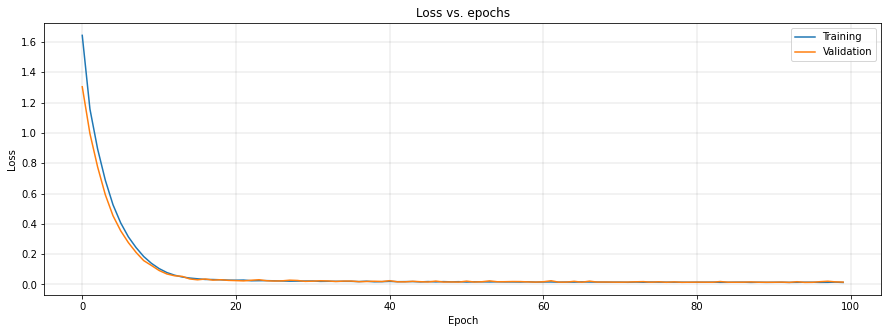

In [16]:
plt.figure(6,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time series forecasting with trainned neural network

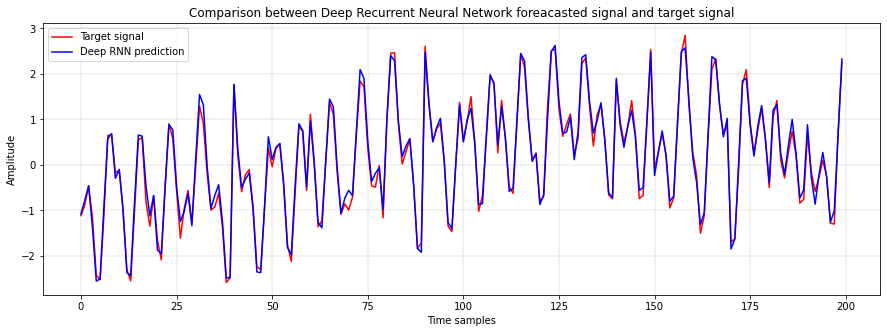

Deep Recurrent Neural network's SNR: 19.831822750009188
Mean Square Error: 0.01559720820378134


In [17]:
deep_RNN_predictions = model_deep_rnn.predict(test_set_x[...,np.newaxis])
deep_RNN_err         = deep_RNN_predictions - test_set_y

plt.figure(7,figsize=(15, 5))

plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_RNN_predictions[:20,:].flatten(),'b',label='Deep RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_RNN_err),2)))
deep_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_RNN_sigpow - deep_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_RNN_predictions,test_set_y)))


----------------------------------------------------------------------
## Method-4: Deep convolutional neural network 
----------------------------------------------------------------------


 ### Build a Deep convolutional neural network

In [18]:
model_deep_cnn = Sequential([Conv1D(filters=5, kernel_size=4, activation='tanh',input_shape=[batch_size-predict_step,1]),
                             AveragePooling1D(pool_size=4),
                             Flatten(),
                             Dense(16, activation='relu'),
                             Dense(predict_step)
                             ])

model_deep_cnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 243, 5)            25        
_________________________________________________________________
average_pooling1d (AveragePo (None, 60, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                170       
Total params: 5,011
Trainable params: 5,011
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [19]:
start      = time.time()
history    = model_deep_cnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Training completed in : 4517.33ms


### Display of training and validation losses in the network training

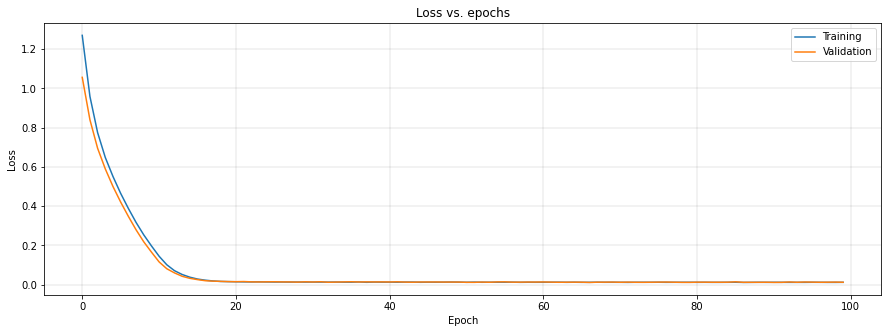

In [20]:
plt.figure(8,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

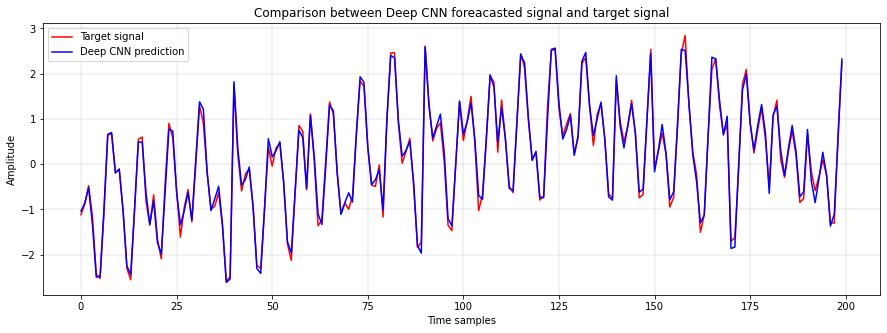

Deep Recurrent Neural network's SNR: 20.702002170135692
Mean Square Error: 0.012765238326678615


In [21]:
deep_CNN_predictions = model_deep_cnn.predict(test_set_x[...,np.newaxis])
deep_CNN_err         = deep_CNN_predictions - test_set_y

plt.figure(9,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_CNN_predictions[:20,:].flatten(),'b',label='Deep CNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep CNN foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_CNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_CNN_err),2)))
deep_CNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_CNN_sigpow - deep_CNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_CNN_predictions,test_set_y)))

----------------------------------------------------------------------
## Summary:  Comparison of methods
----------------------------------------------------------------------



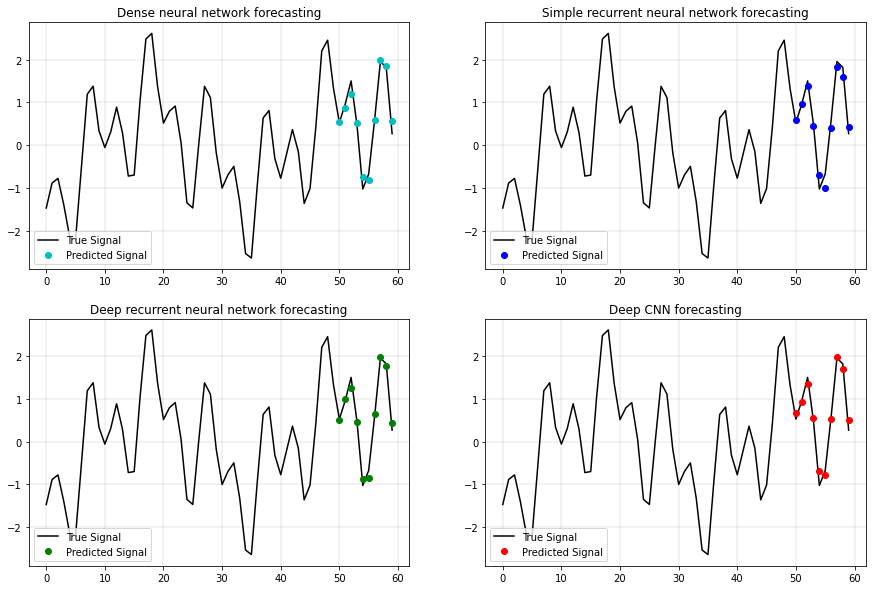

In [22]:
plt.figure(9,figsize=(15, 10))

plt.subplot(221)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],dnn_predictions[10,:]),axis=0),'co',label='Predicted Signal')
plt.title('Dense neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')

plt.subplot(222)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],simple_RNN_predictions[10,:]),axis=0),'bo',label='Predicted Signal')
plt.title('Simple recurrent neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')


plt.subplot(223)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],deep_RNN_predictions[10,:]),axis=0),'go',label='Predicted Signal')
plt.title('Deep recurrent neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')

plt.subplot(224)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],deep_CNN_predictions[10,:]),axis=0),'ro',label='Predicted Signal')
plt.title('Deep CNN forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')


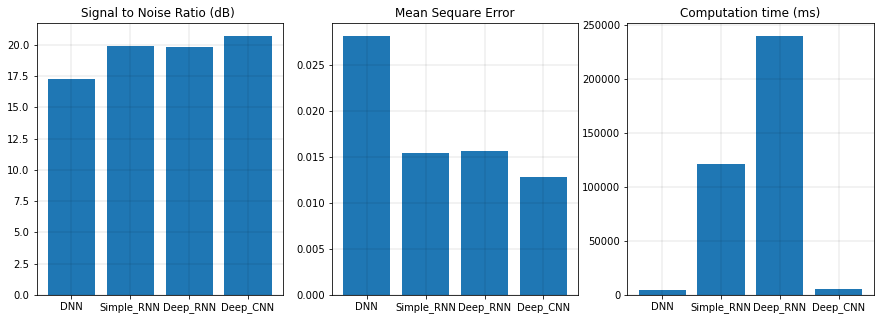

In [23]:
names = ['DNN', 'Simple_RNN', 'Deep_RNN','Deep_CNN']
SNR   = [dnn_sigpow - dnn_mse, simple_RNN_sigpow - simple_RNN_mse,deep_RNN_sigpow - deep_RNN_mse, deep_CNN_sigpow - deep_CNN_mse]
MSE   = [np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(simple_RNN_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(deep_RNN_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(deep_CNN_predictions,test_set_y))]
Time  = [4682.42,121381.42,239705.38,5380.72]


plt.figure(10,figsize=(15, 5))
plt.subplot(131)
plt.bar(names, SNR)
plt.title('Signal to Noise Ratio (dB) ')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(132)
plt.bar(names, MSE)
plt.title('Mean Sequare Error')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(133)
plt.bar(names, Time)
plt.title('Computation time (ms)')
# plt.suptitle('Comparison of Performance')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


By comparing the prediction results obtained from these 4 different neural network architectures, you can see the Deep recurrent neural network (RNN) and deep convolutional neural network (CNN) gives the highest signal to noise ratios as well as the least mean square errors. If we further compare the computational cost of deep RNN and deep CNN, we can see later network structure requires much less computation cost compared to the Deep RNN architecture. Thus I would recommend using deep convolutional neural networks among the proposed neural network architectures for 1D time series forecasting.  To further evaluate the neural network-based time series forecasting methods, further experiments will need to be tested against traditional parametric or non-parametric methods such as the moving-average (MA) model and autoregressive integrated moving average (ARIMA) model methods.

### Reference

- Geron, Aurelien, Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow
- Time series forecasting, Tensorflow 2 Tutorials.